In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=f854bf52065d8e738769664ae58e51d70b2a47e236f014b1da4a81c47e8de5d7
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.0 

In [ ]:
import torch
torch.manual_seed(16194236825314548155)
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Defining Architectures

In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, bert_encoding_size, num_labels, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.num_layers = num_layers
        self.embedding_size = bert_encoding_size
        self.num_labels = num_labels

        # Define the embedding layer to project the input into the model's feature space
        self.embedding = nn.Linear(bert_encoding_size, bert_encoding_size)

        # Define the transformer layer
        self.transformer_layer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=bert_encoding_size,
                nhead=2,
                dim_feedforward=2048,
                dropout=dropout,
                activation='relu',
                batch_first = True,
                # is_causal = True
            ),
            num_layers=num_layers
        )

        # Define the output layer to predict the labels
        self.output_layer = nn.Linear(bert_encoding_size, num_labels)

    def forward(self, input):
        # Project the input into the model's feature space
        input_embedded = self.embedding(input)

        # Apply the transformer layer
        transformer_output = self.transformer_layer(input_embedded)

        # Predict the labels
        output = self.output_layer(transformer_output)

        return output
    
    def forward_partial(self, input):
        # Project the input into the model's feature space
        input_embedded = self.embedding(input)

        # Reshape the input into the expected format of Transformer
        # input_embedded = input_embedded.permute(1, 0, 2)

        # Apply the transformer layer
        transformer_output = self.transformer_layer(input_embedded)

        # Reshape the output back into the expected format
        # transformer_output = transformer_output.permute(1, 0, 2)

        return transformer_output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RelationshipPredictorModel(nn.Module):
    def __init__(self, 
                 bert_encoding_size, 
                 transformer_model,
                 relationship_dim = 4,
                 hidden_dim = 256):
        super(RelationshipPredictorModel, self).__init__()

        self.transformer = transformer_model
        self.relationship_dim = relationship_dim
        self.hidden_dim = hidden_dim

        # Define the MLP
        self.mlp = nn.Sequential(
                    nn.Linear(bert_encoding_size, hidden_dim),
                    nn.Tanh(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, relationship_dim)
        )



    def forward(self, input):
        # Project the input into the model's feature space
        transformer_out = self.transformer.forward_partial(input)
        output = self.mlp(transformer_out)

        return output
    

# Pre-training

## Testing forward Pass of Transformer

In [ ]:
ntokens = 10000  # size of vocabulary
emsize = 4  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

In [ ]:
n_batch = 2
n_characters = 2
character_dim = 4
length_dialogue = 5
bd = 4
ed = 2
ps = 1

criterion = torch.nn.MSELoss()
model = TransformerModel(bert_encoding_size=bd, num_labels=1, num_layers=2, dropout=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for _ in range(10):
    optimizer.zero_grad()
    ds = torch.ones((n_batch, length_dialogue, bd))

    output = model(ds)
    y = torch.rand((n_batch, length_dialogue, ps))

    loss = criterion(output, y)
    loss.backward()
    optimizer.step()



## Data Processing for Pre-training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data_df = data_d.T.drop_duplicates().T
data_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.5719,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0..."
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.0,0.0,"[-0.14115169644355774, 0.5629909634590149, -0...."
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.0,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0...."
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
...,...,...,...,...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1682,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1683,CAPULET,MONTAGUE,7,9,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,-0.127267,"[-0.21812646090984344, 0.143050417304039, -0.1..."
1684,CAPULET,PRINCE,7,11,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,0.062967,"[-0.21812646090984344, 0.143050417304039, -0.1..."


In [ ]:
import numpy as np
character_translation = {index: name for index, name in enumerate(character_enum['character'])}

In [ ]:
def story_to_tensor(df):
  dialogues = np.array([[float(val) for val in be.strip('][').split(', ')] for be in df['bert']])
  speakers = np.array([int(val) for val in df['speaker_index']])[:, np.newaxis]
  listeners = np.array([int(val) for val in df['listener_index']])[:, np.newaxis]

  sentiments = np.array([float(val) for val in df['dialogue_sentiment']])[:, np.newaxis]

  combined = np.concatenate((speakers, listeners, dialogues), axis=1)

  return torch.tensor(combined), torch.tensor(sentiments).float().to(torch_device)

rj_combined, rj_sentiments = story_to_tensor(data_df)
rj_combined, rj_sentiments = rj_combined[:], rj_sentiments[:]
print(rj_combined.shape, rj_sentiments.shape)

torch.Size([1686, 770]) torch.Size([1686, 1])


In [ ]:
mask_token = 5 * torch.ones((rj_combined.shape[-1] - 2)).to(torch_device).float()
masks_rows = []
total_examples = 100
mask_prob = 0.1

all_examples = rj_combined.repeat(total_examples, 1, 1).to(torch_device).float()
labels = rj_sentiments.repeat(total_examples, 1, 1).to(torch_device)

for i in range(total_examples):
    
  mask_rows = (torch.rand((rj_combined.shape[0])).to(torch_device) <= mask_prob)
  masks_rows += [mask_rows]
  all_examples[i, mask_rows, 2:] = mask_token

print(all_examples.shape, labels.shape)

torch.Size([100, 1686, 770]) torch.Size([100, 1686, 1])


In [ ]:
from torch.utils.data import DataLoader

n_batch = 20

train_size = int(0.8 * all_examples.shape[0])
test_size = int(0.2 * all_examples.shape[0])

train_data = all_examples[:train_size]
test_data = all_examples[train_size:]

train_labels = labels[:train_size]
test_labels = labels[train_size:]

## Training Pipeline

Total dialogues: 80
0
20
40
60


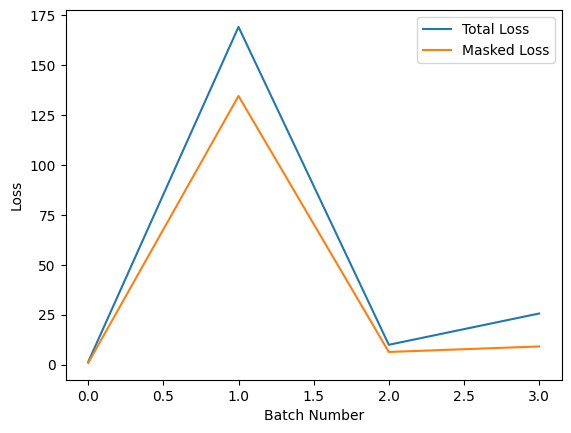

0
20
40
60


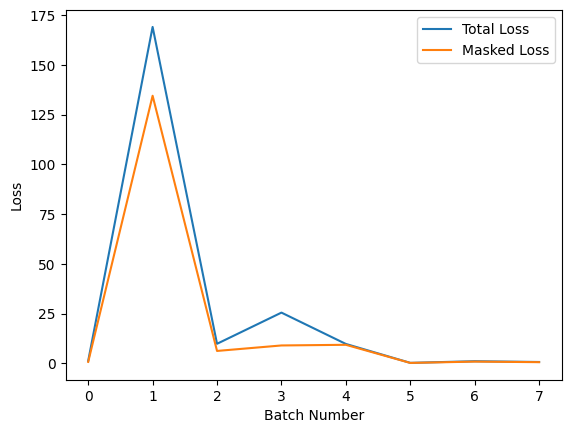

0
20
40
60


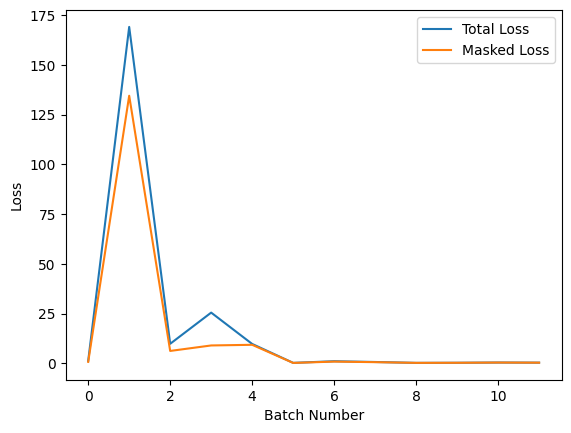

0
20
40
60


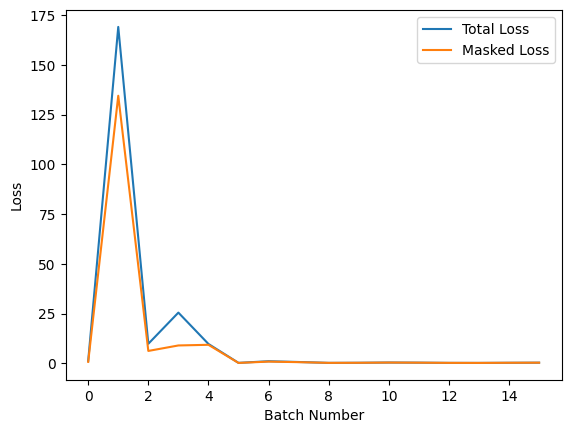

0
20
40
60


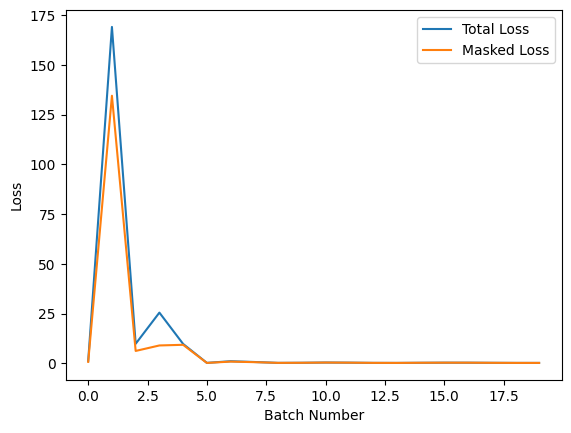

0
20
40
60


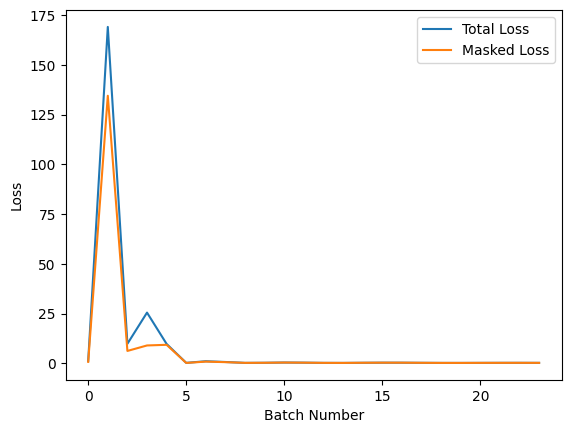

0
20
40
60


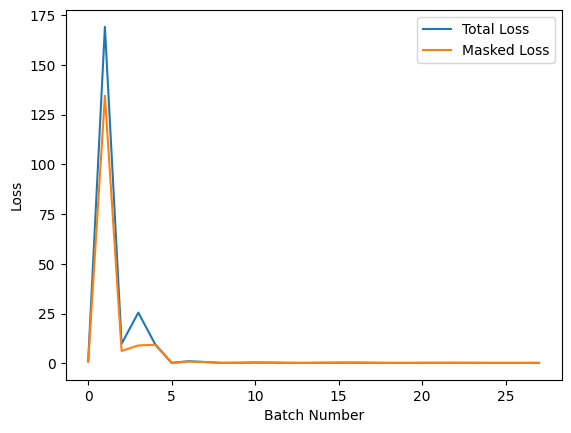

0
20
40
60


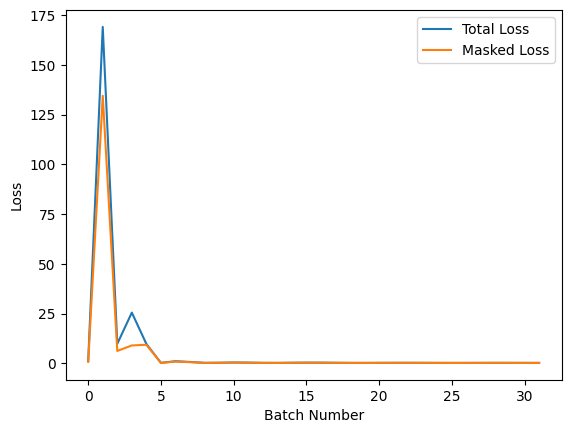

0
20
40
60


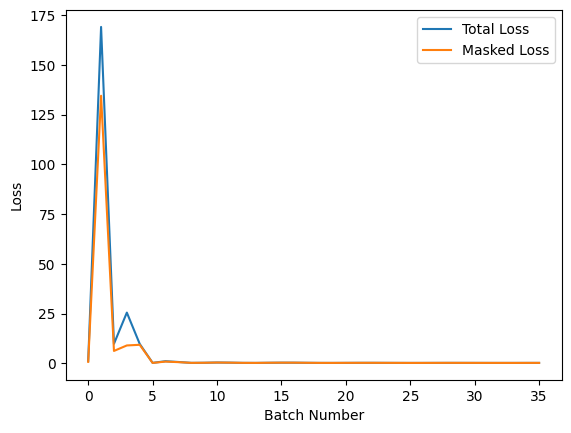

0
20
40
60


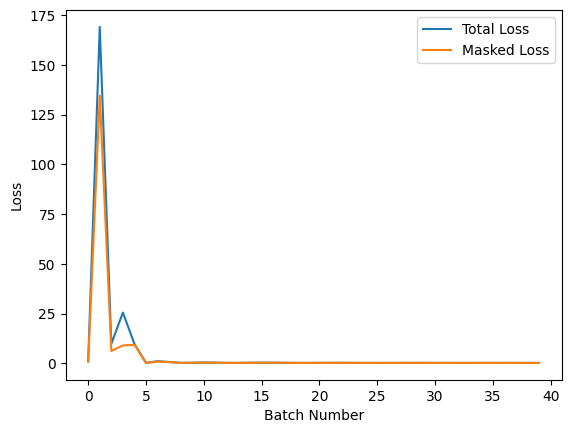

In [ ]:
import tqdm
import matplotlib.pyplot as plt

character_embedding_dim = 8
bert_dim = 768
edge_dim = 8
pred_size = 1

EPOCHS = 10

transformer_model = TransformerModel(bert_encoding_size=bert_dim + 2, num_labels=pred_size, num_layers=2, dropout=0.1).to(torch_device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters())

n_characters = len(character_enum)

torch.autograd.set_detect_anomaly(True)
all_losses = []
masked_losses = []
print('Total dialogues:', len(train_data))
for e in range(EPOCHS):
  for i in range(0, train_data.shape[0], n_batch):
    print(i)
    # character_embeddings = torch.rand((n_batch, n_characters, character_embedding_dim)).to(torch_device)

    labels = train_labels[i:i+n_batch].to(torch_device)
    data = train_data[i:i+n_batch].to(torch_device)
    batch_mask = masks_rows[i: i+n_batch]

    lin_pred = transformer_model(data)
    # Compute and print loss
    loss = criterion(lin_pred.to(torch_device), labels)
    masked_pred = []
    masked_label =[]
    for j, masked_row in enumerate(batch_mask):
        masked_pred += [lin_pred[j, masked_row]]
        masked_label += [labels[j, masked_row]]
    masked_pred = torch.cat(masked_pred)
    masked_label = torch.cat(masked_label)
    masked_loss = criterion(masked_pred.to(torch_device), masked_label.to(torch_device))
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), 0.5)
    loss.backward()
    optimizer.step()

    masked_losses += [float(masked_loss.cpu().detach().numpy())]
    all_losses += [float(loss.cpu().detach().numpy())]

  plt.plot(all_losses, label="Total Loss")
  plt.plot(masked_losses, label="Masked Loss")
  plt.xlabel("Batch Number")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


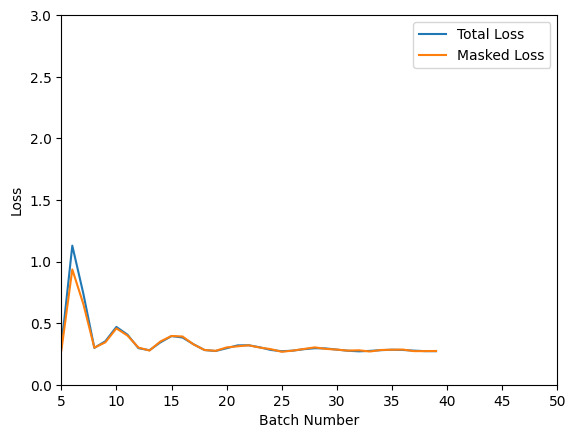

In [ ]:
# Looking at tail
plt.plot(all_losses, label="Total Loss")
plt.plot(masked_losses, label="Masked Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.xlim((5, 50))
plt.ylim((0, 3))
plt.legend()
plt.show()

In [ ]:

test_loss = []
for i in range(0, test_data.shape[0], n_batch):
    print(i)
    # character_embeddings = torch.rand((n_batch, n_characters, character_embedding_dim)).to(torch_device)

    labels = test_labels[i:i+n_batch].to(torch_device)
    data = test_data[i:i+n_batch].to(torch_device)

    lin_pred = transformer_model(data)
    
    # Compute and print loss
    loss = criterion(lin_pred.to(torch_device), labels)

    # Zero gradients, perform a backward pass, and update the weights.

    test_loss += [float(loss.cpu().detach().numpy())]

print(test_loss)
# plt.plot(test_loss)
# plt.show()


0
[0.2728107273578644]


In [ ]:
def get_avg_losses(loss, size):
    """
    For the list of losses, create a new list averaging together every size elements
    """
    avg_loss = []
    for i in range(0, len(loss), size):
        avg_loss.append(sum(loss[i:i+size])/size)
    return avg_loss[:-1]
  
#avg_losses = get_avg_losses(all_losses, 200)
# plt.xlim((10,50))
# plt.ylim((0,1))
# plt.plot(all_losses)

# Fine-tuning

## Testing Forward pass of Relationship Predictor

In [ ]:
n_batch = 2
n_characters = 2
character_dim = 4
length_dialogue = 1686
rd = 4
print(train_data.shape)
criterion = torch.nn.MSELoss()
relationship_model = RelationshipPredictorModel(bert_dim + 2, transformer_model).to(torch_device)
optimizer = torch.optim.Adam(relationship_model.parameters(), lr=0.001)
for _ in range(10):
    optimizer.zero_grad()
    ds = torch.ones((n_batch, length_dialogue, bert_dim + 2)).to(torch_device)

    output = relationship_model(train_data[0:n_batch])
    y = torch.rand((n_batch, length_dialogue, 4)).to(torch_device)

    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

torch.Size([80, 1686, 770])


## Data Processing for Relationship Predictor

In [ ]:
character_translation

{0: 'CHORUS',
 1: 'SAMPSON',
 2: 'GREGORY',
 3: 'ABRAM',
 4: 'BENVOLIO',
 5: 'TYBALT',
 6: 'FIRST CITIZEN',
 7: 'CAPULET',
 8: 'LADY CAPULET',
 9: 'MONTAGUE',
 10: 'LADY MONTAGUE',
 11: 'PRINCE',
 12: 'ROMEO',
 13: 'PARIS',
 14: 'SERVANT',
 15: 'NURSE',
 16: 'JULIET',
 17: 'MERCUTIO',
 18: 'FIRST SERVANT',
 19: 'SECOND SERVANT',
 20: 'CAPULET’S COUSIN',
 21: 'FRIAR LAWRENCE',
 22: 'PETER',
 23: 'WE SHALL BE MUCH UNFURNISH’D FOR THIS TIME',
 24: 'GO WAKEN JULIET, GO AND TRIM HER UP',
 25: 'FIRST MUSICIAN',
 26: 'SECOND MUSICIAN',
 27: 'THIRD MUSICIAN',
 28: 'BALTHASAR',
 29: 'WELL, JULIET, I WILL LIE WITH THEE TONIGHT',
 30: 'APOTHECARY',
 31: 'FRIAR JOHN',
 32: 'PAGE',
 33: 'THE BOY GIVES WARNING SOMETHING DOTH APPROACH',
 34: 'STOP THY UNHALLOW’D TOIL, VILE MONTAGUE',
 35: 'FIRST WATCH',
 36: 'SECOND WATCH',
 37: 'THIRD WATCH. HERE IS A FRIAR THAT TREMBLES, SIGHS, AND WEEPS'}

In [ ]:
inverse_character_translation = {}
for v, k in character_translation.items():
    inverse_character_translation[k] = v

In [ ]:
inverse_character_translation

{'CHORUS': 0,
 'SAMPSON': 1,
 'GREGORY': 2,
 'ABRAM': 3,
 'BENVOLIO': 4,
 'TYBALT': 5,
 'FIRST CITIZEN': 6,
 'CAPULET': 7,
 'LADY CAPULET': 8,
 'MONTAGUE': 9,
 'LADY MONTAGUE': 10,
 'PRINCE': 11,
 'ROMEO': 12,
 'PARIS': 13,
 'SERVANT': 14,
 'NURSE': 15,
 'JULIET': 16,
 'MERCUTIO': 17,
 'FIRST SERVANT': 18,
 'SECOND SERVANT': 19,
 'CAPULET’S COUSIN': 20,
 'FRIAR LAWRENCE': 21,
 'PETER': 22,
 'WE SHALL BE MUCH UNFURNISH’D FOR THIS TIME': 23,
 'GO WAKEN JULIET, GO AND TRIM HER UP': 24,
 'FIRST MUSICIAN': 25,
 'SECOND MUSICIAN': 26,
 'THIRD MUSICIAN': 27,
 'BALTHASAR': 28,
 'WELL, JULIET, I WILL LIE WITH THEE TONIGHT': 29,
 'APOTHECARY': 30,
 'FRIAR JOHN': 31,
 'PAGE': 32,
 'THE BOY GIVES WARNING SOMETHING DOTH APPROACH': 33,
 'STOP THY UNHALLOW’D TOIL, VILE MONTAGUE': 34,
 'FIRST WATCH': 35,
 'SECOND WATCH': 36,
 'THIRD WATCH. HERE IS A FRIAR THAT TREMBLES, SIGHS, AND WEEPS': 37}

In [ ]:
# "Character Pair: [Family, Friendship, Love]"
"""
Here's what the vector elements represent:

Friendship/Alliance: If the element is 1, it means the characters are friends or allies.
Love/Attraction: If the element is 1, it means the characters have feelings of love or attraction towards each other.
Hatred/Enmity: If the element is 1, it means the characters hate or are enemies of each other.
Family Relation: If the element is 1, it means the characters are related by blood or marriage.
Servitude: If the element is 1, it means one character is in service to the other.
Rivalry: If the element is 1, it means the characters are rivals.
Deception: If the element is 1, it means one character is deceiving or lying to the other.
Disrespect: If the element is 1, it means one character shows disrespect to the other.
Neutral: If the element is 0, it means there is no significant relationship between the characters.
"""
construct_relationship_dict = {
  ('ABRAM', 'BALTHASAR'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('ABRAM', 'GREGORY'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('APOTHECARY', 'FRIAR LAWRENCE'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('BALTHASAR', 'ABRAM'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('BALTHASAR', 'ROMEO'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('BENVOLIO', 'MERCUTIO'): [1, 0, 1, 0, 0, 1, 0, 0, 0],
  ('BENVOLIO', 'ROMEO'): [1, 0, 0, 0, 0, -1, 0, -1, 0],
  ('BENVOLIO', 'TYBALT'): [-1, -1, -1, 0, 0, -1, 0, 0, 0],
  ('CAPULET', 'FIRST CITIZEN'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('CAPULET', 'LADY CAPULET'): [-1, -1, -1, 1, 0, 0, 0, 1, 0],
  ('CAPULET', 'PARIS'): [1, 0, 0, 0, 0, 0, 0, 1, 0],
  ('CAPULET', 'TYBALT'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('FIRST CITIZEN', 'CAPULET'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FIRST MUSICIAN', 'SECOND MUSICIAN'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FIRST MUSICIAN', 'THIRD MUSICIAN'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FIRST SERVANT', 'PETER'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FIRST WATCH', 'SECOND WATCH'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FRIAR JOHN', 'FRIAR LAWRENCE'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FRIAR LAWRENCE', 'APOTHECARY'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FRIAR LAWRENCE', 'FRIAR JOHN'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FRIAR LAWRENCE', 'JULIET'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('FRIAR LAWRENCE', 'ROMEO'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('GREGORY', 'ABRAM'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('JULIET', 'FRIAR LAWRENCE'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('JULIET', 'LADY CAPULET'): [1, 0, 0, 0, 0, 0, 0, -1, 0],
  ('JULIET', 'NURSE'): [-1, -1, -1, 0, 0, -1, 0, 1, 0],
  ('JULIET', 'PARIS'): [-1, 0, 0, 0, 0, -1, 0, -1, 0],
  ('JULIET', 'ROMEO'): [1, 1, 1, 0, 0, 1, 0, -1, 0],
  ('LADY CAPULET', 'CAPULET'): [-1, -1, -1, 0, 0, 0, 0, 1, 0],
  ('LADY CAPULET', 'JULIET'): [1, 0, 0, 0, 0, 0, 0, -1, 0],
  ('LADY CAPULET', 'NURSE'): [1, 0, 0, 0, 0, 0, 0, 1, 0],
  ('LADY CAPULET', 'TYBALT'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('LADY MONTAGUE', 'MONTAGUE'): [-1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('MERCUTIO', 'BENVOLIO'): [1, 0, -1, 0, 0, -1, 0, 0, 0],
  ('MERCUTIO', 'ROMEO'): [1, 0, 0, 0, 0, -1, 0, 0, 0],
  ('MONTAGUE', 'LADY MONTAGUE'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('MONTAGUE', 'ROMEO'): [1, 0, 0, 0, 0, 0, 0, -1, 0],
  ('NURSE', 'JULIET'): [-1, -1, -1, 0, 0, -1, 0, 1, 0],
  ('NURSE', 'LADY CAPULET'): [1, 0, 0, 0, 0, 0, 0, -1, 0],
  ('NURSE', 'PARIS'): [-1, 0, 0, 0, 0, -1, 0, 0, 0],
  ('NURSE', 'ROMEO'): [1, 1, 1, 0, 0, 1, 0, 0, 0],
  ('PARIS', 'CAPULET'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('PARIS', 'JULIET'): [1, 0, 0, 0, 0, 1, 0, -1, 0],
  ('PARIS', 'NURSE'): [1, 0, 0, 0, 0, 1, 0, 0, 0],
  ('PARIS', 'ROMEO'): [-1, 0, 0, 0, 0, -1, 0, 1, 0],
  ('PRINCE', 'CAPULET'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('PRINCE', 'MONTAGUE'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('ROMEO', 'BENVOLIO'): [1, 0, -1, 0, 0, -1, 0, 0, 0],
  ('ROMEO', 'CAPULET'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('ROMEO', 'JULIET'): [1, 1, 1, 0, 0, 1, 0, -1, 0],
  ('ROMEO', 'MERCUTIO'): [1, 0, 0, 0, 0, -1, 0, 0, 0],
  ('ROMEO', 'MONTAGUE'): [1, 0, 0, 0, 0, 0, 0, -1, 0],
  ('ROMEO', 'PARIS'): [-1, 0, 0, 0, 0, -1, 0, 1, 0],
  ('SECOND MUSICIAN', 'FIRST MUSICIAN'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('SECOND WATCH', 'FIRST WATCH'): [1, 0, 0, 0, 0, 0, 0, 0, 0],
  ('TYBALT', 'CAPULET'): [-1, 0, -1, 0, 0, -1, 0, 1, 0],
  ('TYBALT', 'JULIET'): [-1, 0, 0, 0, 0, -1, 0, 1, 0],
  ('TYBALT', 'LADY CAPULET'): [-1, 0, -1, 0, 0, -1, 0, 1, 0]}

In [ ]:
character_speaker_df = data_df[['speaker', 'listener', 'speaker_index', 'listener_index']]
character_speaker_df

,speaker,listener,speaker_index,listener_index
0,CHORUS,SAMPSON,0,1
1,SAMPSON,CHORUS,1,0
2,SAMPSON,GREGORY,1,2
3,GREGORY,SAMPSON,2,1
4,GREGORY,SAMPSON,2,1
...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7
1682,MONTAGUE,CAPULET,9,7
1683,CAPULET,MONTAGUE,7,9
1684,CAPULET,PRINCE,7,11


In [ ]:
relationships = []
speakers = list(character_speaker_df['speaker'])
listeners = list(character_speaker_df['listener'])
for ind in character_speaker_df.index:
  speaker = speakers[ind]
  listener = listeners[ind]
  relation = construct_relationship_dict.get((speaker, listener), [0.0]*9)
  relationships += [str(list(np.abs(np.array(relation, dtype=float))))]
character_speaker_df['relations'] = relationships
character_speaker_df = character_speaker_df.drop_duplicates()
character_speaker_df

<ipython-input-25-3b2f353767fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  character_speaker_df['relations'] = relationships


,speaker,listener,speaker_index,listener_index,relations
0,CHORUS,SAMPSON,0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,SAMPSON,CHORUS,1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,SAMPSON,GREGORY,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,GREGORY,SAMPSON,2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
50,SAMPSON,ABRAM,1,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...
1663,FRIAR LAWRENCE,PRINCE,21,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1670,PRINCE,BALTHASAR,11,28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1671,BALTHASAR,PRINCE,28,11,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1674,PRINCE,PAGE,11,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
# shuffle relationships
character_speaker_df = character_speaker_df.sample(frac=1)

def story_to_tensor(df):
  dialogues = np.array([np.ones(bert_dim)*5 for be in df['relations']])
  speakers = np.array([int(val) for val in df['speaker_index']])[:, np.newaxis]
  listeners = np.array([int(val) for val in df['listener_index']])[:, np.newaxis]

  relationship_vect =  np.array([[float(val) for val in be.strip('][').split(', ')] for be in df['relations']])

  combined = np.concatenate((speakers, listeners, dialogues), axis=1)

  return torch.tensor(combined), torch.tensor(relationship_vect).float().to(torch_device)

rj_masked_diag, rj_relations = story_to_tensor(character_speaker_df)
rj_masked_diag, rj_relations = rj_masked_diag[:], rj_relations[:]
print(rj_masked_diag.shape, rj_relations.shape)

torch.Size([199, 770]) torch.Size([199, 9])


In [ ]:
from torch.utils.data import DataLoader

n_batch = 20

train_size = int(0.8 * rj_masked_diag.shape[0])
test_size = int(0.2 * rj_masked_diag.shape[0])

train_data = rj_masked_diag[:train_size]
test_data = rj_masked_diag[train_size:]

train_labels = rj_relations[:train_size]
test_labels = rj_relations[train_size:]

## Finetuning Training Pipeline

Total relationships: 159
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140
0
20
40
60
80
100
120
140


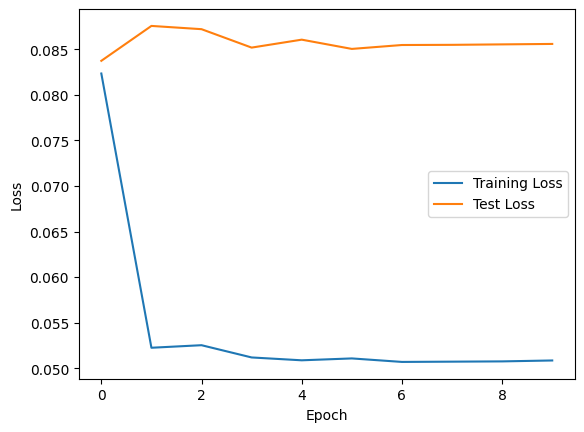

In [ ]:
import tqdm
import matplotlib.pyplot as plt

character_embedding_dim = 8
bert_dim = 768
edge_dim = 8
pred_size = 1

EPOCHS = 10

criterion = torch.nn.MSELoss()
relationship_model = RelationshipPredictorModel(bert_dim + 2, transformer_model, 9).to(torch_device)
optimizer = torch.optim.Adam(relationship_model.parameters(), lr=0.001)


torch.autograd.set_detect_anomaly(True)
all_losses = []
print('Total relationships:', len(train_data))
test_data = test_data.to(torch_device).float()
test_labels = test_labels.to(torch_device)
test_loss = []
for e in range(EPOCHS):
  loss_per_epoch = []
  for i in range(0, train_data.shape[0], n_batch):
    print(i)
    # character_embeddings = torch.rand((n_batch, n_characters, character_embedding_dim)).to(torch_device)

    labels = train_labels[i:i+n_batch].to(torch_device)
    data = train_data[i:i+n_batch].to(torch_device)

    lin_pred = relationship_model(data.float())
    # Compute and print loss
    loss = criterion(lin_pred.to(torch_device), labels)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(relationship_model.parameters(), 0.5)
    loss.backward()
    optimizer.step()
    loss_per_epoch += [float(loss.cpu().detach().numpy())]


  lin_pred_test = relationship_model(test_data)
  loss_test = criterion(lin_pred_test.to(torch_device), test_labels)

  test_loss += [float(loss_test.cpu().detach().numpy())]
  all_losses += [np.mean(np.array(loss_per_epoch))]
plt.plot(all_losses, label="Training Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
